In [5]:
import math
import numpy as np
from collections import Counter, defaultdict
import itertools
from functools import lru_cache
from itertools import chain, zip_longest
import pickle, random
from tqdm.notebook import tqdm
import copy
from glob import glob
from pprint import pprint
from copy import deepcopy
import pickle as pck
from functools import cache
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

from utils import *

In [19]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

title_font = 22
subplot_font = 14
plot_font = 18
legend_font = 16
col_font = subplot_font + 4
fig_dpi = 300

ylim_pad_factor = 0.05

In [7]:
fwd_wksigma_to_dens = {}
for pck_file in glob("fwd/dens/*.pck"):
    with open(pck_file, 'rb') as pck_in:
        fwd_wksigma_to_dens.update(pck.load(pck_in))
print(len(fwd_wksigma_to_dens))
pprint(sorted((fwd_wksigma_to_dens.keys())))

52
[(2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 2),
 (2, 4, 3),
 (2, 5, 2),
 (2, 5, 3),
 (2, 5, 4),
 (2, 6, 2),
 (2, 7, 2),
 (2, 7, 3),
 (2, 8, 2),
 (2, 9, 2),
 (2, 10, 2),
 (2, 11, 2),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 2),
 (3, 3, 2),
 (3, 4, 2),
 (3, 4, 3),
 (3, 5, 2),
 (3, 6, 2),
 (3, 7, 2),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 2),
 (4, 3, 2),
 (4, 4, 2),
 (4, 5, 2),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 2, 2),
 (5, 6, 2),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (7, 1, 2),
 (7, 1, 3),
 (8, 1, 2),
 (9, 1, 2),
 (10, 1, 2),
 (11, 1, 2)]


In [124]:
def style(ax, w=None):
    # ax.set_facecolor("#fbfbfb")
    ax.set_axisbelow(True) 
    ax.grid(False)
    ax.grid(True, axis="x", color='#ccc',linewidth=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if w:
        ax.spines['bottom'].set_visible(False)
        ax.set_ylim(ymin=1/w * (1-ylim_pad_factor), ymax=None)
        ax.axhline(1/w, label="$\\frac{1}{w}$", linestyle="dotted", linewidth=1, color='black')
    else:
        ax.spines['bottom'].set_visible(True)
        ax.set_ylim(ymin=0, ymax=0.8)


In [88]:

w_range = list(range(2, 5))
sigma=2
ax_width = int(len(w_range)**(1/2))
ax_height = math.ceil(len(w_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(8)


for idx, w in enumerate(w_range):
    k_range = list(range(1, 21))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    # ax = axs[int(idx / ax_width), idx % ax_width]
    ax = axs[idx // ax_width]
    style(ax)
    ax.axhline(1/w, label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_2$", color="green")
    ax.plot(k_range, suff_bounded, label="$g^\\prime_\\sigma$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    
    prop={'size': subplot_font}
    ax.set_title(f"$w={w}$", y=1.0, pad=-14)
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds for $\\sigma=2$", fontsize=title_font)
fig.savefig(f"media/bound-fwd-sigma2.png", dpi=fig_dpi)
plt.close(fig)


In [73]:

sigma_range = list(range(2, 5))
ax_width = int(len(sigma_range)**(1/2))
ax_height = math.ceil(len(sigma_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(8)

k=1
for idx, sigma in enumerate(sigma_range):
    w_range = list(range(2, 13))
    my_densities = [aperiodic_bound(w, k, sigma) for w in w_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for w in w_range]
    
    ax = axs[idx // ax_width]
    style(ax)
    ax.plot(w_range, [1/w for w in w_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(w_range, [ragnar_WABI_LB(w, k) for w in w_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(w_range, [ragnar_ceil_LB(w, k) for w in w_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(w_range, my_densities, label="$g_\\sigma$", color="green")
    opt_w = []
    opt_dens = []
    opt_color = []
    for w in w_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_w.append(w)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")

    ax.scatter(opt_w, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    ax.set_title(f"$\\sigma={sigma}$", y=1.0, pad=-14)
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    ax.set_ylim(ymin=0)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$w$", y=.04, fontsize=plot_font)
fig.supylabel("Density", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds $(k=1)$", fontsize=title_font)
fig.savefig(f"media/bound-fwd-k1.png", dpi=fig_dpi)
plt.close(fig)


In [82]:

sigma_range = list(range(2, 5))
w=2
ax_width = int(len(sigma_range)**(1/2))
ax_height = math.ceil(len(sigma_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(8)

for idx, sigma in enumerate(sigma_range):
    k_range = list(range(1, 21))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    ax = axs[idx // ax_width]
    style(ax)
    ax.plot(k_range, [1/w for k in k_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_\\sigma$", color="green")
    ax.plot(k_range, suff_bounded, label="$g^\\prime_\\sigma$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    
    ax.set_title(f"$\\sigma={sigma}$", y=1.0, pad=-14)
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds $(w=2)$", fontsize=title_font)
fig.savefig(f"media/bound-fwd-w2.png", dpi=fig_dpi)
# fig.show()
plt.close(fig)


In [83]:

sigma_range = list(range(2, 5))
w=2
ax_width = 2
ax_height = len(sigma_range)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(12)
# fig.subplots_adjust(wspace=.35)

for idx, sigma in enumerate(sigma_range):
    k_range = list(range(1, 21))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    ax = axs[idx, 0]
    ax.plot(k_range, [1/w for k in k_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_\sigma$", color="green")
    ax.plot(k_range, suff_bounded, label="$g^\\prime_\sigma$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

    if sigma != sigma_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    else:
        ax.set_xlabel("k")

k=1
for idx, sigma in enumerate(sigma_range):
    w_range = list(range(2, 13))
    my_densities = [aperiodic_bound(w, k, sigma) for w in w_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for w in w_range]
    
    ax = axs[idx, 1]
    ax.plot(w_range, [1/w for w in w_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(w_range, [ragnar_WABI_LB(w, k) for w in w_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(w_range, [ragnar_ceil_LB(w, k) for w in w_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(w_range, my_densities, label="$g_\sigma$", color="green")
    opt_w = []
    opt_dens = []
    opt_color = []
    for w in w_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_w.append(w)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")

    ax.scatter(opt_w, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    
    if sigma != sigma_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    else:
        ax.set_xlabel("w")

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_font(prop)


pad = 5
for ax, sigma in zip(axs[:,0], sigma_range):
    ax.annotate(f"$\sigma={sigma}$", xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center')

ax = axs[0][0]
ax.annotate(f"$w=2$", xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

ax = axs[0][1]
ax.annotate(f"$k=1$", xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5, 0), loc='upper center', prop={'size': legend_font}, ncols=6)
# fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density", x=-.01, fontsize=plot_font)
fig.suptitle("Forward density lower bounds ($w=2$ or $k=1$)", fontsize=title_font)
fig.savefig(f"media/bound-fwd-w2andk1.png", dpi=fig_dpi)
#ig.show()


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_114178/47187073.py:19: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(k_range, my_densities, label="$g_\sigma$", color="green")
/tmp/ipykernel_114178/47187073.py:20: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(k_range, suff_bounded, label="$g_\sigma$'", color="green", linestyle="--", linewidth=1)
/tmp/ipykernel_114178/47187073.py:58: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(w_range, my_densities, label="$g_\sigma$", color="green")
/tmp/ipykernel_114178/47187073.py:90: SyntaxWarning: invalid escape sequence '\s'
  ax.annotate(f"$\sigma={sigma

In [127]:

ax_width = 3
ax_height = 3
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(wspace=.25)

w_range = list(range(2,5))
sigma = 2
for idx, w in enumerate(w_range):
    k_range = list(range(1, 15))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    # ax = axs[int(idx / ax_width), idx % ax_width]
    ax = axs[idx, 0]
    style(ax, w)
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_2$", color="green")
    ax.plot(k_range, suff_bounded, label="$g^\\prime_2$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    
    prop={'size': subplot_font}
    ax.set_title(f"$w={w}$  ", loc="right", y=1.0, pad=-14, fontsize=subplot_font+2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylim(ymax=(1+ylim_pad_factor)*my_densities[0])
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

    if w != w_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    else:
        ax.set_xlabel("$k$", color="black")

sigma_range = list(range(2, 5))
w = 2
for idx, sigma in enumerate(sigma_range):
    k_range = list(range(1, 15))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    ax = axs[idx, 1]
    style(ax, w)
    # ax.plot(k_range, [1/w for k in k_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_\\sigma$", color="green")
    ax.plot(k_range, suff_bounded, label="$g^\\prime_\\sigma$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    
    ax.set_title(f"$\\sigma={sigma}$  ", loc="right", y=1.0, pad=-14, fontsize=subplot_font+2)
    ax.set_ylim(ymax=(1+ylim_pad_factor)*my_densities[0])
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

    if sigma != sigma_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    else:
        ax.set_xlabel("$k$", color="black")

k=1
for idx, sigma in enumerate(sigma_range):
    w_range = list(range(2, 13))
    my_densities = [aperiodic_bound(w, k, sigma) for w in w_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for w in w_range]
    
    ax = axs[idx, 2]
    style(ax)
    ax.plot(w_range, [1/w for w in w_range], label="$\\frac{1}{w}$", linestyle="dotted", linewidth=1,color='black')
    ax.plot(w_range, [ragnar_WABI_LB(w, k) for w in w_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(w_range, [ragnar_ceil_LB(w, k) for w in w_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(w_range, my_densities, label="$g_\\sigma$", color="green")
    ax.plot(w_range, suff_bounded, label="$g^\\prime_\\sigma$", color="green", linestyle="--", linewidth=1)
    opt_w = []
    opt_dens = []
    opt_color = []
    for w in w_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_w.append(w)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")

    ax.scatter(opt_w, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
    prop={'size': subplot_font}
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title(f"$\\sigma={sigma}$  ", loc="right", y=1.0, pad=-14, fontsize=subplot_font+1)
    # ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    # ax.set_ylim(ymin=0)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

    if sigma != sigma_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    else:
        ax.set_xlabel("$w$", color="black")

pad = 5
# for ax, sigma in zip(axs[:,0], sigma_range):
#     ax.annotate(f"$\\sigma={sigma}$", xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#         xycoords=ax.yaxis.label, textcoords='offset points',
#         size='large', ha='right', va='center')

ax = axs[0][0]
ax.annotate(f"$\\sigma=2$", xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size=col_font, ha='center', va='baseline')

ax = axs[0][1]
ax.annotate(f"$w=2$", xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size=col_font, ha='center', va='baseline')

ax = axs[0][2]
ax.annotate(f"$k=1$", xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size=col_font, ha='center', va='baseline')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5, 0), loc='upper center', prop={'size': legend_font}, ncols=6)
# fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density", x=0.03, fontsize=plot_font)
fig.suptitle("Forward density lower bounds and ILP results", fontsize=title_font)
fig.savefig(f"media/bound-fwd-grid.svg", dpi=fig_dpi, bbox_inches='tight')
# fig.show()
plt.close(fig)


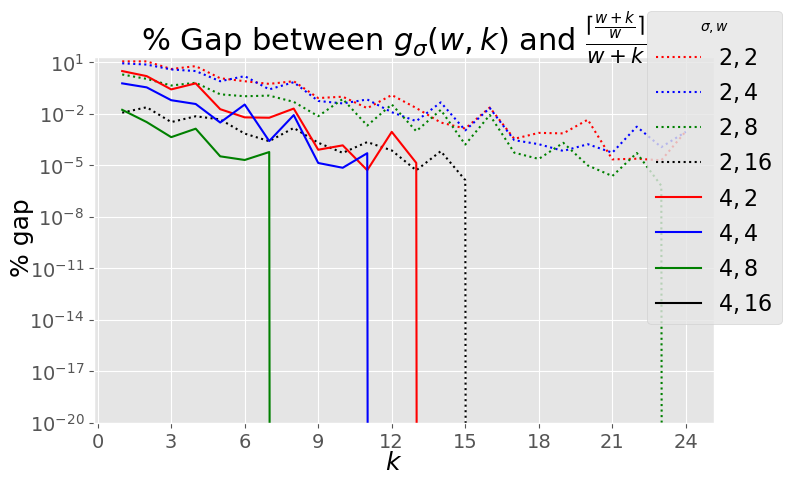

In [166]:

w_range = list([2, 4, 8, 16])
colors = ["red", "blue", "green", "black"]
ax_width = int(len(w_range)**(1/2))
ax_height = math.ceil(len(w_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, ax = plt.subplots()
fig.set_figheight(4.75)
fig.set_figwidth(8)

for sigma in (2, 4):
    for idx, w in enumerate(w_range):
        k_range = list(range(1, 25, 1))
        my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
        ax.plot(
            k_range, 
            [100*(aperiodic_bound(w, k, sigma) - (ragnar_ceil_LB(w, k))) / aperiodic_bound(w, k, sigma) for k in k_range], 
            label=f"${sigma}, {w}$", 
            color=colors[idx],
            linestyle="dotted" if sigma==2 else "solid")
        
        prop={'size': subplot_font}
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_ylim((1e-20, 20))
        ax.set_yscale("log")


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_font(prop)
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', prop={'size': legend_font}, title="$\sigma, w$")
fig.supxlabel("$k$", y=0, fontsize=plot_font)
fig.supylabel("% gap", fontsize=plot_font)
fig.suptitle(f"% Gap between $g_\sigma(w,k)$" + " and $\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", fontsize=title_font)
fig.savefig(f"media/gap-sigma24.png", dpi=fig_dpi)
fig.show()


In [167]:
prev_sigma = 0
sigma_to_count = {sigma: sum(s == sigma for (w, k, s) in fwd_wksigma_to_dens) for sigma in range(5)}


for (w, k, sigma), dens in sorted(fwd_wksigma_to_dens.items(), key=lambda pair: (pair[0][2], pair[0][0], pair[0][1])):
    line = ""
    if sigma != prev_sigma:
        prev_w = 0
        # line += f"\multirow{{{sigma_to_count[sigma]}}}*{{{sigma}}}"
        print('---------')
    # else:
    #     line += "            "
    if w != prev_w:
        print("\\hline")
    prev_w = w
    line += f" {w:<2} & {k:<2} &  {float(dens):.4f} & {str(dens):<11} \\\\"
    prev_sigma = sigma
    print(line)

---------
\hline
 2  & 1  &  0.7500 & 3/4         \\
 2  & 2  &  0.6250 & 5/8         \\
 2  & 3  &  0.6250 & 5/8         \\
 2  & 4  &  0.5781 & 37/64       \\
 2  & 5  &  0.5781 & 37/64       \\
 2  & 6  &  0.5586 & 143/256     \\
 2  & 7  &  0.5586 & 143/256     \\
 2  & 8  &  0.5459 & 559/1024    \\
 2  & 9  &  0.5459 & 559/1024    \\
 2  & 10 &  0.5386 & 1103/2048   \\
 2  & 11 &  0.5386 & 1103/2048   \\
\hline
 3  & 1  &  0.5625 & 9/16        \\
 3  & 2  &  0.4688 & 15/32       \\
 3  & 3  &  0.4531 & 29/64       \\
 3  & 4  &  0.4375 & 7/16        \\
 3  & 5  &  0.4062 & 13/32       \\
 3  & 6  &  0.4023 & 103/256     \\
 3  & 7  &  0.4014 & 411/1024    \\
\hline
 4  & 1  &  0.4375 & 7/16        \\
 4  & 2  &  0.3750 & 3/8         \\
 4  & 3  &  0.3516 & 45/128      \\
 4  & 4  &  0.3398 & 87/256      \\
 4  & 5  &  0.3359 & 43/128      \\
\hline
 5  & 1  &  0.3594 & 23/64       \\
 5  & 2  &  0.3047 & 39/128      \\
 5  & 6  &  0.2734 & 35/128      \\
\hline
 6  & 1  &  0.2969 